In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

# choose either cuda or cpu
device = 'cuda'
#device = 'cpu'

torch.set_default_device(device)
print('Using device:', torch.get_default_device())

# for plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'] # standard color sequence

# smoothing SGD loss trajectories 
def smooth(lossTraj, window=10): 
    cum = torch.cumsum(lossTraj, 0)
    return (cum[window:]-cum[:-window])/window

# fit power law f(t)=ct^(-xi) using two anchor points on the trajectory
def fitPow(lossTraj, anchorPoints=[0.4, 0.8], offset=0): 
    if offset:
        lossTraj = torch.cat([torch.empty((offset,)), lossTraj])
    N = len(lossTraj)
    t1 = int(N**anchorPoints[0])
    t2 = int(N**anchorPoints[1]) 
    xi = -torch.log(lossTraj[t2]/lossTraj[t1])/np.log(t2/t1)
    c = lossTraj[t1]/t1**(-xi)
    return xi, c, t1, t2

# reconstruct linear transformation parameters alpha, b, c, D of the Corner SGD 
# from the hyperparameters M (memsize), theta, l, A
def getParamsCorner(params):
    params = params | {} # make a copy
    memsize, theta, l, A = params['memsize'], params['theta'], params['l'], params['A']
    h = l/np.sqrt(memsize)                 
    params['b'] = torch.ones((memsize,))
    params['c'] = ((2-theta)*h/A*(torch.exp(-h*(torch.arange(memsize)+0.5))-1)*
             torch.exp(-(2-theta)*h*(torch.arange(memsize)+0.5)))
    params['D'] = 1-torch.exp(-h*(torch.arange(memsize)+0.5))
    params['alpha'] = torch.tensor(((2-theta)*h/A*np.exp(-(2-theta)/2*h)*(1-np.exp(-(2-theta)*h*memsize))/(1-np.exp(-(2-theta)*h))))
    
    return params 

# reconstruct all necessary optimization params from given params
def get_params(params, t=None): 
    if params['alg'] == 'plain SGD':
        params1 = params | {'memsize': 0}
    elif params['alg'] == 'corner':
        params1 = getParamsCorner(params)
    else:
        params1 = params
    
    return params1 

# linear transformation in one step of Corner SGD 
def stepCorner(grad, u, params):
    if params['memsize'] == 0: # plain SGD
        dw = -params['alpha']*grad
        return dw, None
    else: # general Corner SGD
        dw = -params['alpha']*grad+torch.einsum('j,ij->i', params['b'], u)
        u1 = torch.einsum('i,j->ij', grad, params['c']) 
        u2 = torch.einsum('j,ij->ij', params['D'], u)
        u = u1+u2 
        return dw, u   

# weight initialization by zero
def initWcornerZero(Nweights, memsize=0):
    weights = {'w':torch.zeros(Nweights)
              }
    weights['w'].requires_grad = True    
    if memsize > 0:
        weights['u'] = torch.zeros((Nweights, memsize))   
    else:
        weights['u'] = None
    return weights

# MSE loss
def Loss(target, prediction): 
    return 0.5*torch.mean((target-prediction)**2)

Using device: cuda:0


# Fitting a 1D indicator

## Setup

In [2]:
def getTarget1dIndicator(x): # target indicator function 
    return 0.5*(torch.sign((x-0.25)*(0.75-x))+1)

def model1dIndicator(w, x): # linear model (shallow NN with fixed first layer)
    Nweights = len(w)
    h = torch.linspace(0, 1, Nweights)
    preact = x.reshape((-1,1))-h
    postact = torch.relu(preact)
    out = torch.einsum('ij,j-> i', postact, w)/np.sqrt(Nweights)      
    return out

## Training

In [3]:
%%time

Nweights = 100000 # number of model weights
batchSize = 100 # |B|
Niter = 100000 # optimization iterations 

# algorithms to compare
algL = [
    {'alg': 'plain SGD', 'alpha': 10.},
    {'alg': 'corner', 'memsize': 5, 'theta': 1.8, 'l':5., 'A': 0.1},
    ]
assert len(algL) <= len(colors)/2 # too many cases hinder visualization 

lossTrajL = [] # list of training loss trajectories per algorithm
WeightL = [] # List of final trained weights per algorithm

for alg in algL:
    print ('====================')
    print (alg)
    params = get_params(alg)     
    # print (params) # to also view reconstructed parameters

    weights = initWcornerZero(Nweights, params['memsize'])
    lossTraj = torch.empty((Niter,))

    t0 = time.time()
    for t in range(Niter):
        x = torch.rand(batchSize)
        target = getTarget1dIndicator(x)
        prediction = model1dIndicator(weights['w'], x)
        loss = Loss(target, prediction)
        loss.backward()
        dw, weights['u'] = stepCorner(weights['w'].grad, weights['u'], params)
        weights['w'].data = weights['w'].data+dw
        weights['w'].grad.zero_()
        lossTraj[t] = loss.detach()    
    t1 = time.time()
    
    WeightL.append(weights['w'])
    lossTrajL.append(lossTraj)

    print ('Final loss:', float(lossTraj[-1]))
    print ('Training time:', t1-t0)
    
print ('**************')

{'alg': 'plain SGD', 'alpha': 10.0}
Final loss: 0.006997998338192701
Training time: 71.221914768219
{'alg': 'corner', 'memsize': 5, 'theta': 1.8, 'l': 5.0, 'A': 0.1}
Final loss: 0.00016439474711660296
Training time: 79.32274556159973
**************
CPU times: total: 2min 17s
Wall time: 2min 30s


## Postprocessing and visualization

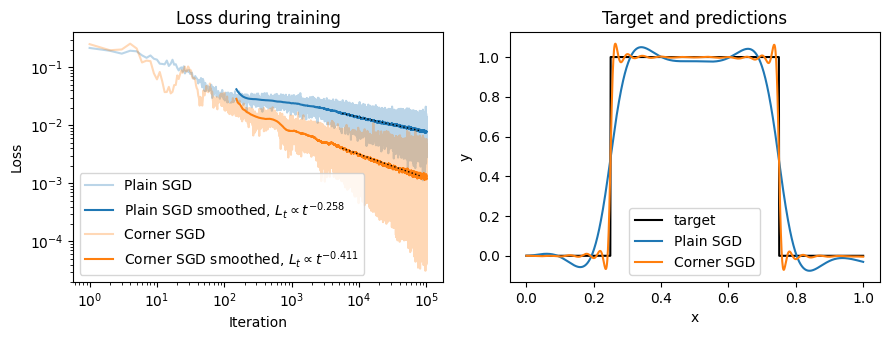

In [7]:
# smoothing window
window = 300
assert window%2 == 0 # must be even 

# smoothed loss trajectories
lossTrajSmoothedL = []
for i, alg in enumerate(algL):
    lossTrajSmoothedL.append(smooth(lossTrajL[i], window))

# anchor points used to estimate power laws
anchorPoints = [0.75, 0.98]

# fitted power laws
fittedPowLawL = []
for i, alg in enumerate(algL):
    xi, c, t1, t2 = fitPow(lossTrajSmoothedL[i], anchorPoints, offset=window//2)
    fittedPowLawL.append({'xi_est':xi, 'c_est':c})

plt.figure(figsize=(9,3.5))
plt.subplot(121)
for i, alg in enumerate(algL):
    # loss trajectory
    label = ', '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner SGD')])
    plt.loglog(np.arange(Niter)+1,
               lossTrajL[i].cpu().numpy(), color=colors[i], label=label, alpha=0.3)
    # smoothed loss trajectory
    label = ', '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner SGD')+' smoothed', 
                       '$L_t\\propto t^{-%0.3g}$' %(fittedPowLawL[i]['xi_est'])]) 
    plt.loglog(np.arange(window//2, Niter-window//2)+1, lossTrajSmoothedL[i].cpu(), color=colors[i], label=label)
    # fitted power law
    t_interval_est = np.arange(t1,t2)
    plt.loglog(t_interval_est+1, float(fittedPowLawL[i]['c_est'])*t_interval_est**float(-fittedPowLawL[i]['xi_est']), ':', color='k', lw='1')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Loss during training')
plt.legend()

plt.subplot(122)
xTest = torch.linspace(0,1,1000)
yTarget = getTarget1dIndicator(xTest)
plt.plot(xTest.cpu().numpy(), yTarget.cpu().detach().numpy(), 'k', label='target')
for i, alg in enumerate(algL):
    xTest = torch.linspace(0,1,1000)
    yTest = model1dIndicator(WeightL[i], xTest)
    label = ', '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner SGD')])
    plt.plot(xTest.cpu().numpy(), yTest.cpu().detach().numpy(), color=colors[i], label=label)

plt.title('Target and predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

#plt.savefig('indicator1d_%d.pdf' %batchSize)
plt.savefig('indicator1d_%d.png' %batchSize)
plt.show()

# MNIST

In [8]:
from keras.datasets import mnist
(Xtrain0, Ytrain0), (Xtest0, Ytest0) = mnist.load_data()

assert Xtrain0.shape == (60000, 28, 28) and Ytrain0.shape == (60000,)
assert Xtest0.shape == (10000, 28, 28) and Ytest0.shape == (10000,)
assert np.min(Xtrain0) == 0 and np.max(Xtrain0) == 255
assert np.min(Ytrain0) == 0 and np.max(Ytrain0) == 9

# convert to 1D arrays and rescale
Xtrain1 = np.reshape(Xtrain0, (-1, 28*28))/256.
Xtest1 = np.reshape(Xtest0, (-1, 28*28))/256.
# centering
means = Xtrain1.mean(axis=0) # pixel-wise means
Xtrain2 = Xtrain1-means
Xtest2 = Xtest1-means

# create torch tensors on default device
Xtrain = torch.Tensor(Xtrain2).to(device)
Ytrain = torch.Tensor(Ytrain0).long().to(device)
Xtest = torch.Tensor(Xtest2).to(device)
Ytest = torch.Tensor(Ytest0).long().to(device)

# 1-hot encode
Ytrain1hot = torch.nn.functional.one_hot(Ytrain, 10)
Ytest1hot = torch.nn.functional.one_hot(Ytest, 10)

## Model setup 

In [9]:
# One-hidden-layer network 
def modelMnist(W, X, H, includeBiases=False):
    '''
    W: all weights in one array
    X: inputs, (Ninputs, 28*28)    
    H: width
    '''
    w0_size = 28*28*H
    h0_size = H
    w1_size = H*10
    h1_size = 10
    
    w0 = W[:w0_size].reshape((28*28,H))
    h0 = W[w0_size:w0_size+h0_size].reshape((H,))
    w1 = W[w0_size+h0_size:w0_size+h0_size+w1_size].reshape((H,10))
    h1 = W[w0_size+h0_size+w1_size:].reshape((10,))

    # hidden layer
    pre_activations = X@w0+h0*includeBiases
    assert pre_activations.shape == (X.shape[0], H)

    post_activations = torch.maximum(pre_activations,
                                     torch.tensor(0))/np.sqrt(H)  # ReLU, NTK normalization

    # output layer
    out = post_activations@w1+h1*includeBiases
    assert out.shape == (X.shape[0], 10)

    return out

def initWeightsMnist(H, # network width
                     scale=3e-1, # rescale weights
                     memsize=0,
                    ):
    w0 = torch.randn((28*28*H,))
    h0 = torch.randn((H,))
    w1 = torch.randn((H*10,))
    h1 = torch.randn((10,))
    W = scale*torch.cat([w0, h0, w1, h1])
    weights = {'w':W, 'u':None} 
    weights['w'].requires_grad = True
    if memsize > 0:
        weights['u'] = torch.zeros((len(weights['w']), memsize))
    return weights

## Training

In [14]:
%%time

H = 1000 # network width
batchSize = 1000
assert len(Xtrain)%batchSize == 0
batchesPerTrain = len(Xtrain)//batchSize
Niter = 50000

# algorithms to compare
algL = [
    {'alg': 'plain SGD', 'alpha': 1e1},
    {'alg': 'corner', 'A': 1, 'memsize': 5, 'theta': 1.3, 'l':5.},
    {'alg': 'corner', 'A': 1, 'memsize': 5, 'theta': 1.8, 'l':5.},    
    ]
assert len(algL) <= len(colors)/2 # too many cases hinder visualization 

lossTrajL = [] # list of training loss trajectories per algorithm
WeightL = [] # List of final trained weights per algorithm

for alg in algL:
    print ('====================')
    print (alg)
    params = get_params(alg)     
    # print (params) # to also view reconstructed parameters

    weights = initWeightsMnist(H, memsize=params['memsize'])
    lossTraj = torch.empty((Niter,))

    t0 = time.time()
    for t in range(Niter):
        xTrainBatch = Xtrain[batchSize*(t%batchesPerTrain):batchSize*(t%batchesPerTrain)+batchSize]
        yTrainBatch = Ytrain1hot[batchSize*(t%batchesPerTrain):batchSize*(t%batchesPerTrain)+batchSize]
        
        prediction = modelMnist(weights['w'], xTrainBatch, H)
        loss = Loss(yTrainBatch, prediction)
        loss.backward()
        dw, weights['u'] = stepCorner(weights['w'].grad, weights['u'], params)
        weights['w'].data = weights['w'].data+dw
        weights['w'].grad.zero_()
        lossTraj[t] = loss.detach()    
    t1 = time.time()
    
    WeightL.append(weights['w'])
    lossTrajL.append(lossTraj)

    print ('Final loss:', float(lossTraj[-1]))
    print ('Training time:', t1-t0)
    
print ('**************')

{'alg': 'plain SGD', 'alpha': 10.0}
Final loss: 0.0039869011379778385
Training time: 53.669183015823364
{'alg': 'corner', 'A': 1, 'memsize': 5, 'theta': 1.3, 'l': 5.0}
Final loss: 0.002287039067596197
Training time: 67.59946990013123
{'alg': 'corner', 'A': 1, 'memsize': 5, 'theta': 1.8, 'l': 5.0}
Final loss: 0.0013485376257449389
Training time: 67.17534565925598
**************
CPU times: total: 3min 6s
Wall time: 3min 8s


## Postprocessing and visualization

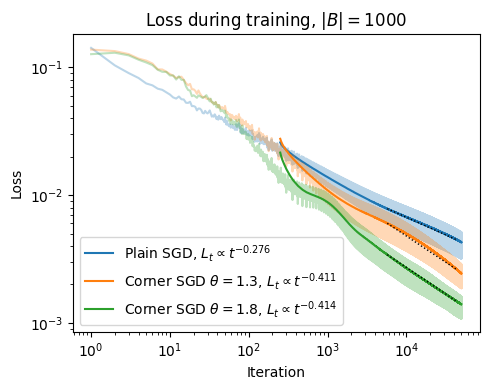

In [15]:
# smoothing window
window = 500
assert window%2 == 0 # must be even 

# smoothed loss trajectories
lossTrajSmoothedL = []
for i, alg in enumerate(algL):
    lossTrajSmoothedL.append(smooth(lossTrajL[i], window))

# anchor points used to estimate power laws
anchorPoints = [0.8, 0.99]

# fitted power laws
fittedPowLawL = []
for i, alg in enumerate(algL):
    xi, c, t1, t2 = fitPow(lossTrajSmoothedL[i], anchorPoints, offset=window//2)
    fittedPowLawL.append({'xi_est':xi, 'c_est':c})

plt.figure(figsize=(5,4))
for i, alg in enumerate(algL):
    # loss trajectory
    plt.loglog(np.arange(Niter)+1, lossTrajL[i].cpu().numpy(), color=colors[i], alpha=0.3)
    # smoothed loss trajectory
    label = ', '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner SGD $\\theta=%0.1f$' %(alg['theta'])),                    
                       '$L_t\\propto t^{-%0.3g}$' %(fittedPowLawL[i]['xi_est'])])
    plt.loglog(np.arange(window//2, Niter-window//2)+1, lossTrajSmoothedL[i].cpu(), color=colors[i], label=label)
    # fitted power law
    t_interval_est = np.arange(t1,t2)
    plt.loglog(t_interval_est+1, float(fittedPowLawL[i]['c_est'])*t_interval_est**float(-fittedPowLawL[i]['xi_est']), ':', color='k', lw='1')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Loss during training, $|B|=%d$' %(batchSize))
plt.legend()
plt.tight_layout()

#plt.savefig('mnistCornerSGD_%d.pdf' %batchSize)
plt.show()

## Training + Testing  

In [16]:
%%time

lossTrajL = [] # training loss trajectories
WeightL = [] # final trained weights
lossTrajTestL = [] # test loss trajectories
errorTrajL = [] # training error trajectories
errorTrajTestL = [] # test error trajectories

for alg in algL:
    print ('====================')
    print (alg)
    params = get_params(alg)     
    # print (params) # to also view reconstructed parameters

    weights = initWeightsMnist(H, memsize=params['memsize'])
    lossTraj = torch.empty((Niter,))
    lossTrajTest = torch.empty((Niter,))
    errorTraj = torch.empty((Niter,))
    errorTrajTest = torch.empty((Niter,))

    t0 = time.time()
    for t in range(Niter):
        xTrainBatch = Xtrain[batchSize*(t%batchesPerTrain):batchSize*(t%batchesPerTrain)+batchSize]
        yTrainBatch = Ytrain1hot[batchSize*(t%batchesPerTrain):batchSize*(t%batchesPerTrain)+batchSize]        
        prediction = modelMnist(weights['w'], xTrainBatch, H)                        
        loss = Loss(yTrainBatch, prediction)        
        loss.backward()
        dw, weights['u'] = stepCorner(weights['w'].grad, weights['u'], params)
        weights['w'].data = weights['w'].data+dw
        weights['w'].grad.zero_()
        
        lossTraj[t] = loss.detach() 
        errorTraj[t] = 1-(torch.argmax(prediction, dim=1)==torch.argmax(yTrainBatch, dim=1)).float().mean()
        
        predTest = modelMnist(weights['w'], Xtest, H)
        lossTest = Loss(Ytest1hot, predTest).detach()
        lossTrajTest[t] = lossTest
        errorTrajTest[t] = 1-(torch.argmax(predTest, dim=1)==torch.argmax(Ytest1hot, dim=1)).float().mean()
                
    t1 = time.time()
    
    WeightL.append(weights['w'])
    lossTrajL.append(lossTraj)
    errorTrajL.append(errorTraj)
    lossTrajTestL.append(lossTrajTest)
    errorTrajTestL.append(errorTrajTest)

    print ('Final loss:', float(lossTraj[-1]))
    print ('Training/testing time:', t1-t0)
    
print ('**************')

{'alg': 'plain SGD', 'alpha': 10.0}
Final loss: 0.004077512305229902
Training/testing time: 153.7767322063446
{'alg': 'corner', 'A': 1, 'memsize': 5, 'theta': 1.3, 'l': 5.0}
Final loss: 0.0023111309856176376
Training/testing time: 179.11010718345642
{'alg': 'corner', 'A': 1, 'memsize': 5, 'theta': 1.8, 'l': 5.0}
Final loss: 0.0013379239244386554
Training/testing time: 178.54503417015076
**************
CPU times: total: 8min 26s
Wall time: 8min 31s


## Postprocessing and visualization

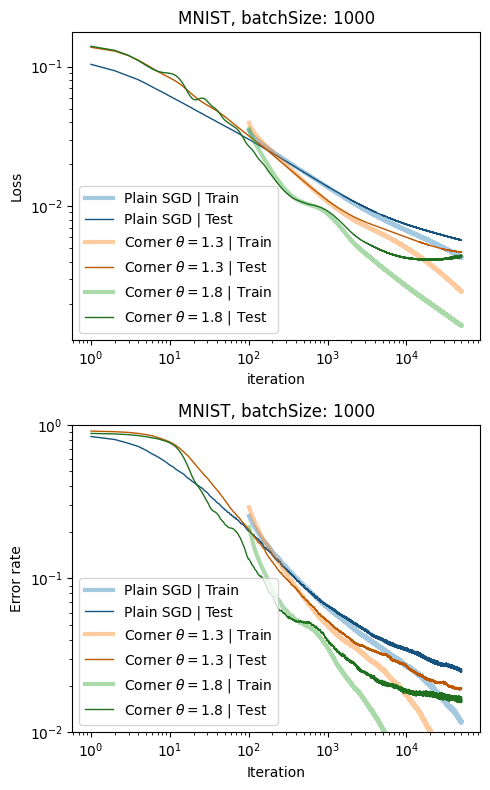

In [17]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# smoothing window
window = 200
assert window%2 == 0 # must be even 

# smoothed loss and error trajectories
lossTrajSmoothedL = []
for i, alg in enumerate(algL):
    lossTrajSmoothedL.append(smooth(lossTrajL[i], window))
errorTrajSmoothedL = []
for i, alg in enumerate(algL):
    errorTrajSmoothedL.append(smooth(errorTrajL[i], window))


plt.figure(figsize=(5,8))
plt.subplot(211)
for i, alg in enumerate(algL):
    # smoothed loss trajectory on training set
    label = ' '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner $\\theta=%0.1f$' %(alg['theta'])),                      
                       '| Train'])
    plt.loglog(np.arange(window//2, Niter-window//2)+1, lossTrajSmoothedL[i].cpu(), lw=3, alpha=0.4, color=colors[i], label=label)
    # loss on test set
    label = ' '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner $\\theta=%0.1f$' %(alg['theta'])),                      
                       '| Test'])
    plt.loglog(torch.arange(Niter).cpu()+1, lossTrajTestL[i].cpu(), '-', lw=1, color=adjust_lightness(colors[i], 0.7),  label=label)

plt.ylabel('Loss')
plt.xlabel('iteration')
plt.title('MNIST, batchSize: %d' %(batchSize))
plt.legend()

plt.subplot(212)
for i, alg in enumerate(algL):
    # smoothed error trajectory on training set
    label = ' '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner $\\theta=%0.1f$' %(alg['theta'])),                      
                       '| Train'])
    plt.loglog(np.arange(window//2, Niter-window//2)+1, errorTrajSmoothedL[i].cpu(), lw=3, alpha=0.4, color=colors[i], label=label)
    # error on test set
    label = ' '.join([('Plain SGD' if alg['alg']=='plain SGD' else 'Corner $\\theta=%0.1f$' %(alg['theta'])),                      
                       '| Test'])
    plt.loglog(torch.arange(Niter).cpu()+1, errorTrajTestL[i].cpu(), '-', lw=1, color=adjust_lightness(colors[i], 0.7),  label=label)

plt.ylim((1e-2,1))
plt.ylabel('Error rate')
plt.xlabel('Iteration')
plt.title('MNIST, batchSize: %d' %(batchSize))
plt.legend()
plt.tight_layout()

#plt.savefig('mnistCornerTest_%d.pdf' %batchSize)
plt.show()